In [ ]:
#Every important library we are gonna use (or not but is usefull to have as a resource)
import requests
import time
import datetime
import json
import websocket
import networkx as nx

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf 
from scipy.stats import shapiro, normaltest, levene
from scipy.stats import chi2_contingency
from datetime import timedelta, date
from collections import defaultdict
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

##### Fetching data and cleaning

In [ ]:
def fetch_spot_data_binance(symbol, interval, startTimes, limit):
    url = 'https://data-api.binance.vision/api/v3/klines'
    
    asset_data_binance = {
        'Time' : [],
        'Open' : [],
    } 
    
    for startTime in startTimes:
        params = {
            'symbol' : symbol,
            'interval' : interval,
            'startTime' : startTime,
            'limit' : limit
        }
    
        response = requests.get(url, params)
        partial_data = response.json()
    
        for entry in partial_data:
             asset_data_binance['Time'].append(float(entry[0]))
             asset_data_binance['Open'].append(float(entry[1]))

    return asset_data_binance

def fetch_spot_data_bitget(symbol, granularity, endTimes, limit):
    url = 'https://api.bitget.com/api/v2/spot/market/history-candles'

    asset_data_bitget = {
        'Time' : [],
        'Open' : []
    }
    
    pause_timer = 0    
    for endTime in endTimes:
        params = {
                'symbol' : symbol,
                'granularity' : granularity,
                'endTime' : endTime,
                'limit' : limit
            }
        pause_timer += 1
        if pause_timer == 18:
            time.sleep(0.5)
            pause_timer = 0
            
        response = requests.get(url, params)
        if response.status_code == 200:
            pre_partial_data = response.json()
            if 'data' in pre_partial_data:
                partial_data = pre_partial_data['data']
                for entry in partial_data:
                    asset_data_bitget['Time'].append(float(entry[0]))
                    asset_data_bitget['Open'].append(float(entry[1]))

    return asset_data_bitget

def fetch_options_data():
    url = 'https://history.deribit.com/api/v2/public/get_instruments'
    params = {
        'currency' : 'BTC',
        'kind' : 'option',
        'expired' : 'true'
    }
    
    response = requests.get(url, params)
    options_data = response.json()

    return options_data.get('result',[])

def trades_per_instrument(instruments_name, start_timestamp, end_timestamp):
    instruments_url = 'https://history.deribit.com/api/v2/public/get_last_trades_by_instrument_and_time'

    instruments_trade = {instrument_name : [] for instrument_name in instruments_name}
    
    for instrument_name in instruments_name:
        params = {
            'instrument_name': instrument_name,
            'start_timestamp': start_timestamp,
            'end_timestamp': end_timestamp,
            'count': 25,  # Adjust as needed
            'sorting': 'asc'
        }
    
        response = requests.get(instruments_url, params=params)
        data = response.json()
        trades = data.get('result', {}).get('trades', [])

        for trade in trades:
            instruments_trade['instrument_name'].append(trade)        

In [ ]:
#Params needed for fetching the spot data.
endTime_0 = int(datetime.datetime(2024, 11, 1).timestamp() * 1000)
start_date = int(datetime.datetime(2018, 8, 18).timestamp() * 1000)

n_hours_to_get = int((endTime_0 - start_date) / (1000 * 60 * 60))

symbol = 'BTCUSDT'
interval = granularity = '1h'
startTimes = [start_date]
endTimes = [endTime_0] #At the end, this list has to have 270+ values, because there are 263 intervals of 200 hours between start_date and endTime_0 (at least)
limit_binance = 1000
limit_bitget = 200

n_requests_binance = int(n_hours_to_get / limit_binance)
n_requests_bitget = int(n_hours_to_get / limit_bitget)
time_interval_binance = 60*60 * 1000 * limit_binance
time_interval_bitget = 60*60 * 1000 * limit_bitget

interval_to_ms = {
    '1h': 60 * 60 * 1000,
    '4h': 4 * 60 * 60 * 1000,
    '6h': 6 * 60 * 60 * 1000,
    '12h': 12 * 60 * 60 * 1000,
    '1d': 24 * 60 * 60 * 1000,
}

asset_data = {}

for i in range(n_requests_binance):
    startTimes.append(startTimes[-1] + time_interval_binance)
for i in range(n_requests_bitget):
    endTimes.insert(0, endTimes[0] - time_interval_bitget)
    

asset_data_binance = fetch_spot_data_binance(symbol, interval, startTimes, limit_binance)
asset_data_bitget = fetch_spot_data_bitget(symbol, granularity, endTimes, limit_bitget)

initial_df_binance = pd.DataFrame(asset_data_binance)
initial_df_bitget = pd.DataFrame(asset_data_bitget)

initial_df_binance['Date'] = pd.to_datetime(initial_df_binance['Time'], unit = 'ms')
initial_df_binance.set_index('Date', inplace = True)
initial_df_binance = initial_df_binance.sort_index()

initial_df_bitget['Date'] = pd.to_datetime(initial_df_bitget['Time'], unit = 'ms')
initial_df_bitget.set_index('Date', inplace = True)
initial_df_bitget = initial_df_bitget.sort_index()

In [ ]:
initial_df = pd.concat([initial_df_binance,initial_df_bitget])
initial_df = initial_df.sort_index()
initial_df = initial_df.drop_duplicates(subset = 'Time')

diff = initial_df['Time'].diff().iloc[1]  
missing = (initial_df['Time'].diff() != diff).sum() - 1 
#If missing = 0, there is no data missing, if missing != 0, there is at least one hour of data missing, probably more.

In [ ]:
pd.set_option('display.max_columns', 114)

##### Data transformation and statistical analysis

In [ ]:
initial_df = initial_df.iloc[9:]
#The initial_df starts at 23:00, I want it to start at 08:00.
df_1h = initial_df.copy()
df_4h = initial_df.resample('4h', origin = 'start').first().copy()
df_6h = initial_df.resample('6h', origin = 'start').first().copy()
df_12h = initial_df.resample('12h', origin = 'start').first().copy()
df_1d = initial_df.resample('1D', origin = 'start').first().copy()

df_1h['returns'] = df_1h['Open'].pct_change()
df_4h['returns'] = df_4h['Open'].pct_change()
df_6h['returns'] = df_6h['Open'].pct_change()
df_12h['returns'] = df_12h['Open'].pct_change()
df_1d['returns'] = df_1d['Open'].pct_change()

window_1h = [24, 48, 72, 96, 120]
window_4h = [24, 30, 36, 42, 48]
window_6h = [16, 20, 24, 28, 32]
window_12h = [14, 28, 42, 56, 70]
window_1d = [7, 14, 30, 60, 90]

for window in window_1h:
    df_1h[f'Volatility_{window}'] = df_1h['returns'].rolling(window=window).std()
    df_1h[f'Log_Volatility_{window}'] = np.log(df_1h[f'Volatility_{window}'])
for window in window_4h:
    df_4h[f'Volatility_{window}'] = df_4h['returns'].rolling(window=window).std()
    df_4h[f'Log_Volatility_{window}'] = np.log(df_4h[f'Volatility_{window}'])
for window in window_6h:
    df_6h[f'Volatility_{window}'] = df_6h['returns'].rolling(window=window).std()
    df_6h[f'Log_Volatility_{window}'] = np.log(df_6h[f'Volatility_{window}'])
for window in window_12h:
    df_12h[f'Volatility_{window}'] = df_12h['returns'].rolling(window=window).std()
    df_12h[f'Log_Volatility_{window}'] = np.log(df_12h[f'Volatility_{window}'])
for window in window_1d:
    df_1d[f'Volatility_{window}'] = df_1d['returns'].rolling(window=window).std()
    df_1d[f'Log_Volatility_{window}'] = np.log(df_1d[f'Volatility_{window}'])

df_1h = df_1h.dropna()
df_4h = df_4h.dropna()
df_6h = df_6h.dropna()
df_12h = df_12h.dropna()
df_1d = df_1d.dropna()

In [ ]:
def calculate_adf(series):
    result = adfuller(series.dropna())  # Drop NaNs before ADF test
    return {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }

adf_results = {}

# List of dataframes and their respective window lists
timeframes = {
    '1h': (df_1h, window_1h),
    '4h': (df_4h, window_4h),
    '6h': (df_6h, window_6h),
    '12h': (df_12h, window_12h),
    '1d': (df_1d, window_1d),
}

for timeframe, (df, windows) in timeframes.items():
    for window in windows:
        column = f'Volatility_{window}'
        if column in df.columns:
            adf_results[f'{timeframe}_{column}'] = calculate_adf(df[column])

In [47]:
adf_results

{'1h_Volatility_24': {'ADF Statistic': -13.32432134072109,
  'p-value': 6.366194303501718e-25,
  'Critical Values': {'1%': -3.430468893266018,
   '5%': -2.861592548487191,
   '10%': -2.566797969803451}},
 '1h_Volatility_48': {'ADF Statistic': -11.387169240857235,
  'p-value': 8.235684617199129e-21,
  'Critical Values': {'1%': -3.4304688954276967,
   '5%': -2.861592549442592,
   '10%': -2.566797970311982}},
 '1h_Volatility_72': {'ADF Statistic': -13.719096655594296,
  'p-value': 1.1972698261700927e-25,
  'Critical Values': {'1%': -3.430468897589454,
   '5%': -2.8615925503980266,
   '10%': -2.5667979708205313}},
 '1h_Volatility_96': {'ADF Statistic': -13.062038694070775,
  'p-value': 2.0379572431109725e-24,
  'Critical Values': {'1%': -3.430468867332003,
   '5%': -2.861592537025096,
   '10%': -2.5667979637025207}},
 '1h_Volatility_120': {'ADF Statistic': -11.985731613447468,
  'p-value': 3.6169836671587543e-22,
  'Critical Values': {'1%': -3.430468882458803,
   '5%': -2.86159254371071,
 

In [48]:
df_1d['Log_Volatility_90'] = np.log(df_1d['Volatility_90']) #Ya lo calculé antes... 
df_1d['Log_Volatility_90_diff'] = df_1d['Log_Volatility_90'].diff()
adf_log_diff = calculate_adf(df_1d['Log_Volatility_90_diff'])
print(adf_log_diff)

{'ADF Statistic': -14.058731476936554, 'p-value': 3.0836831870033336e-26, 'Critical Values': {'1%': -3.433325884732626, '5%': -2.862854651280992, '10%': -2.5674698530991735}}


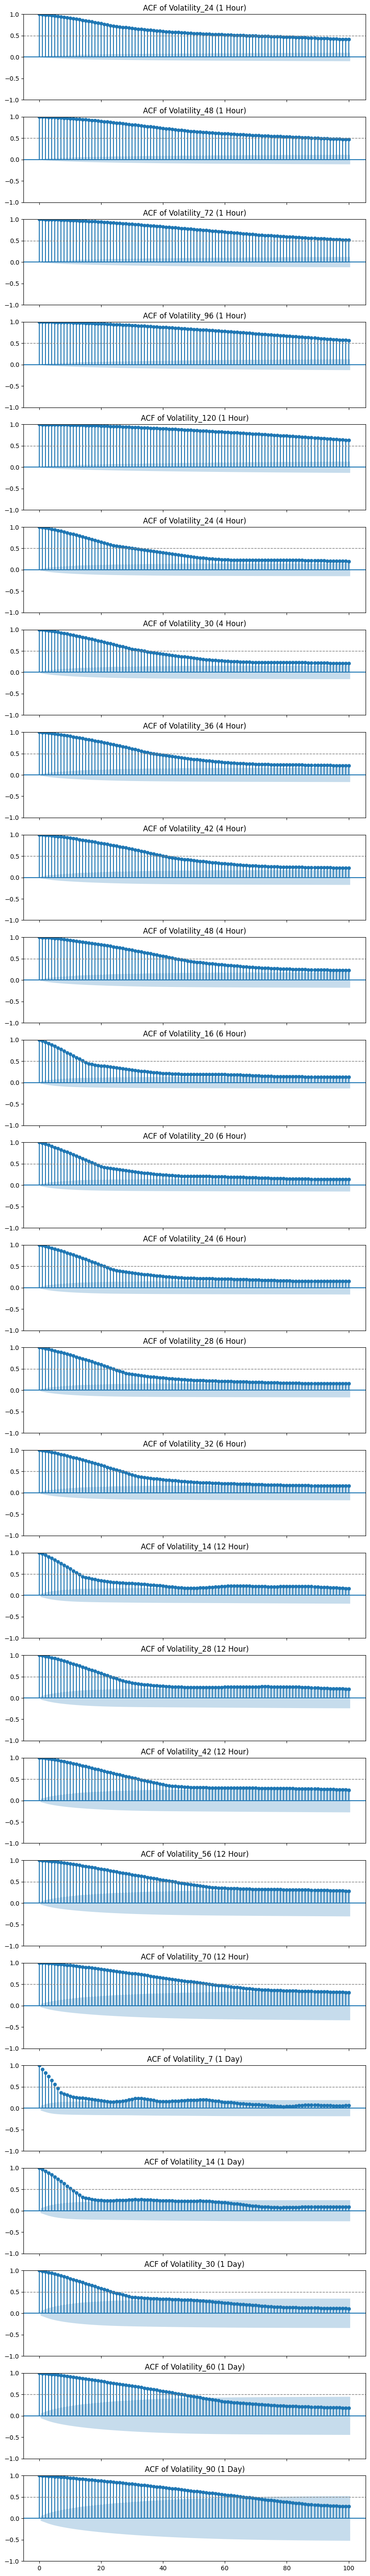

In [49]:
dataframes = [df_1h, df_4h, df_6h, df_12h, df_1d]
titles = ["1 Hour", "4 Hour", "6 Hour", "12 Hour", "1 Day"]
window_sets = {
    "1 Hour": [24, 48, 72, 96, 120],
    "4 Hour": [24, 30, 36, 42, 48],
    "6 Hour": [16, 20, 24, 28, 32],
    "12 Hour": [14, 28, 42, 56, 70],
    "1 Day": [7, 14, 30, 60, 90],
}

# Plot the ACF for all volatility measures
fig, axes = plt.subplots(
    nrows=sum(len(windows) for windows in window_sets.values()), 
    ncols=1, 
    figsize=(10, 75), 
    sharex=True
)

row_idx = 0  # Track the current subplot index
for df, title in zip(dataframes, titles):
    for window in window_sets[title]:
        column_name = f"Volatility_{window}"
        plot_acf(df[column_name].dropna(), lags=100, alpha=0.01, ax=axes[row_idx])
        axes[row_idx].set_title(f"ACF of {column_name} ({title})")
        axes[row_idx].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
        row_idx += 1

plt.show()

In [ ]:
#I'm not even sure I know or understand what this does, but it seems to work.
def calculate_shift(current_hour, lookahead_hours, frequency):
    """
    Calculate the number of rows to shift based on the current hour,
    lookahead period, and data frequency.
    
    Args:
    - current_hour (int): The current hour of the row.
    - lookahead_hours (int): The target lookahead period in hours.
    - frequency (int): The data frequency in hours (e.g., 1 for 1H, 4 for 4H).

    Returns:
    - int: The number of rows to shift.
    """
    if current_hour < 8:
        shift = lookahead_hours + (8 - current_hour)
    elif current_hour > 8 and current_hour <= 19:
        shift = lookahead_hours - (current_hour - 8)
    elif current_hour >= 20:
        shift = lookahead_hours + 8 + 24 - current_hour
    else:
        shift = lookahead_hours
    return int(shift / frequency)

#General function to create future Open price columns
def add_future_open(df, lookahead_hours_list, frequency):
    """
    Add future Open price columns for given lookahead periods.

    Args:
    - df (pd.DataFrame): The DataFrame containing 'Datetime' and 'Open'.
    - lookahead_hours_list (list): List of lookahead periods in hours.
    - frequency (int): The data frequency in hours (e.g., 1 for 1H, 4 for 4H).
    """
    df['Datetime'] = pd.to_datetime(df['Time'], unit='ms')
    for lookahead_hours in lookahead_hours_list:
        col_name = f'Open_{lookahead_hours}h'
        df[col_name] = np.nan
        for i in range(len(df)):
            current_hour = df.iloc[i]['Datetime'].hour
            n_rows_to_shift = calculate_shift(current_hour, lookahead_hours, frequency)
            target_index = i + n_rows_to_shift
            if target_index < len(df):
                df.loc[df.index[i], col_name] = df.iloc[target_index]['Open']

#Apply function to data
add_future_open(df_1h, [48, 72, 96], 1)  #1-hour frequency
add_future_open(df_4h, [72, 96, 120], 4)  #4-hour frequency
add_future_open(df_6h, [96, 120, 144], 6)
add_future_open(df_12h, [120, 144, 168], 12)
add_future_open(df_1d, [168, 240, 480], 24)

In [ ]:
def calculate_static_percentiles(df, volatility_col, percentiles):
    """
    Calculate specified static percentiles for a given volatility column in a DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing the data.
    - volatility_col (str): Column name to calculate percentiles for.
    - percentiles (list): List of percentiles to calculate.

    Returns:
    - dict: Dictionary with percentile as key and value as calculated value.
    """
    return {p: np.percentile(df[volatility_col], p) for p in percentiles}

# Function to add move and percentile columns
def add_move_and_percentile_columns(df, shifts, percentiles, static_percentiles, volatility_col):
    """
    Add columns for percentage moves and percentile-based flags for a specific volatility column.

    Args:
    - df (pd.DataFrame): DataFrame to modify.
    - shifts (dict): Mapping of move column names to shift periods.
    - percentiles (dict): Mapping of percentiles to static values.
    - static_percentiles (dict): Static percentile values for the DataFrame.
    - volatility_col (str): Column name for volatility.
    """
    for col_name, shift_period in shifts.items():
        df[col_name] = ((df['Open'].shift(-shift_period) / df['Open']) - 1) * 100

# Define volatility columns for each timeframe
volatility_columns = {
    '1h': ['Log_Volatility_24', 'Log_Volatility_48', 'Log_Volatility_72', 'Log_Volatility_96', 'Log_Volatility_120'],
    '4h': ['Log_Volatility_24', 'Log_Volatility_30', 'Log_Volatility_36', 'Log_Volatility_42', 'Log_Volatility_48'],
    '6h': ['Log_Volatility_16', 'Log_Volatility_20', 'Log_Volatility_24', 'Log_Volatility_28', 'Log_Volatility_32'],
    '12h': ['Log_Volatility_14', 'Log_Volatility_28', 'Log_Volatility_42', 'Log_Volatility_56', 'Log_Volatility_70'],
    '1d': ['Log_Volatility_7', 'Log_Volatility_14', 'Log_Volatility_30', 'Log_Volatility_60', 'Log_Volatility_90']
}

# Define shifts for each timeframe
shifts_dict = {
    '1h': {'Move_1': 48, 'Move_2': 72, 'Move_3' : 96},
    '4h': {'Move_1': 18, 'Move_2': 24, 'Move_3' : 30},  # 72h/4h = 18 rows, 96h/4h = 24 rows
    '6h': {'Move_1': 16, 'Move_2': 20, 'Move_3' : 24},  # 96h/6h = 16 rows, 120h/6h = 20 rows
    '12h': {'Move_1': 10, 'Move_2': 12, 'Move_3' : 14}, # 5d/12h = 10 rows, 7d/12h = 14 rows
    '1d': {'Move_1': 7, 'Move_2': 10, 'Move_3': 20}  # 7d, 10d, 20d
}

# Process each DataFrame
timeframes = {'1h': df_1h, '4h': df_4h, '6h': df_6h, '12h': df_12h, '1d': df_1d}
percentiles = [20, 80]

for tf, df in timeframes.items():
    volatility_cols = volatility_columns[tf]  # List of volatility columns
    shifts = shifts_dict[tf]

    for volatility_col in volatility_cols:  # Loop through each volatility column
        # Calculate static percentiles for the current column
        static_percentiles = calculate_static_percentiles(df, volatility_col, percentiles)

        # Add percentile-based columns for the current volatility column
        for percentile in percentiles:
            col_name = f'{volatility_col}_{percentile}th_percent'
            df[col_name] = (df[volatility_col] < static_percentiles[percentile]).astype(int) if percentile == 20 else \
                           (df[volatility_col] > static_percentiles[percentile]).astype(int)

        # Add percentage move columns
        add_move_and_percentile_columns(df, shifts, percentiles, static_percentiles, volatility_col)

    # For timeframes 6h, 12h, and 1d, set 'Date' as index
    if tf in ['6h', '12h', '1d']:
        df['Date'] = pd.to_datetime(df['Time'], unit='ms')
        df.set_index('Date', inplace=True)

In [ ]:
def calculate_percentiles(df, volatility_columns, percentiles=[20, 80]):
    percentile_dict = {}
    for col in volatility_columns:
        percentile_dict[col] = {p: np.percentile(df[col], p) for p in percentiles}
    return percentile_dict

# Example: for 1-hour timeframe
volatility_cols = ['Log_Volatility_24', 'Log_Volatility_120']
percentiles = calculate_percentiles(df_1h, volatility_cols, percentiles=[20, 80])

def plot_volatility_with_percentiles(df, volatility_columns, percentiles, title, start = None, end = None):
    if start and end:
        df = df[(df['Datetime'] >= start) & (df['Datetime'] <= end)]
    
    plt.figure(figsize=(12, 8))
    
    for col in volatility_columns:
        plt.plot(df['Datetime'], df[col], label=f'{col}', alpha=1)
        # Add percentile lines
        p20 = percentiles[col][20]
        p80 = percentiles[col][80]
        plt.axhline(y=p20, color='red', linestyle='--', label=f'{col} 20th Percentile')
        plt.axhline(y=p80, color='blue', linestyle='--', label=f'{col} 80th Percentile')
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Log Volatility')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

# Example: Plot for 1-hour timeframe
plot_volatility_with_percentiles(df_1h, volatility_cols, percentiles, "1-Hour Volatility and Percentiles", '2020-01-01', '2021-01-01')

In [ ]:
def compute_move_stats(df, move_columns, volatility_columns, percentile_cols):
    """
    Compute mean and std for move columns based on 20th and 80th percentiles for each volatility window.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.
    - move_columns (list): List of move columns (e.g., ['Move_1', 'Move_2', 'Move_3']).
    - volatility_columns (list): List of volatility columns to analyze.
    - percentile_cols (dict): Dictionary mapping volatility columns to their 20th and 80th percentile columns.

    Returns:
    - pd.DataFrame: DataFrame summarizing the mean and std for each condition.
    """
    results = []

    for vol_col in volatility_columns:
        for move_col in move_columns:
            # Filter based on 20th and 80th percentiles
            is_below_20th = (df[percentile_cols[vol_col]['20th']] == 1)
            is_above_80th = (df[percentile_cols[vol_col]['80th']] == 1)

            # Compute statistics for 20th percentile
            mean_20th = df.loc[is_below_20th, move_col].mean()
            std_20th = df.loc[is_below_20th, move_col].std()

            # Compute statistics for 80th percentile
            mean_80th = df.loc[is_above_80th, move_col].mean()
            std_80th = df.loc[is_above_80th, move_col].std()

            # Append results
            results.append({
                'Volatility Window': vol_col,
                'Move Column': move_col,
                'Percentile': '20th',
                'Mean': mean_20th,
                'Std': std_20th
            })
            results.append({
                'Volatility Window': vol_col,
                'Move Column': move_col,
                'Percentile': '80th',
                'Mean': mean_80th,
                'Std': std_80th
            })

    return pd.DataFrame(results)

# Define columns and percentiles
move_columns = ['Move_1', 'Move_2', 'Move_3']
volatility_columns_1h = ['Log_Volatility_24', 'Log_Volatility_48', 'Log_Volatility_72', 'Log_Volatility_96', 'Log_Volatility_120']
volatility_columns_4h = ['Log_Volatility_24', 'Log_Volatility_30', 'Log_Volatility_36', 'Log_Volatility_42', 'Log_Volatility_48']
volatility_columns_6h = ['Log_Volatility_16', 'Log_Volatility_20', 'Log_Volatility_24', 'Log_Volatility_28', 'Log_Volatility_32']
volatility_columns_12h = ['Log_Volatility_14', 'Log_Volatility_28', 'Log_Volatility_42', 'Log_Volatility_56', 'Log_Volatility_70']
volatility_columns_1d = ['Log_Volatility_7', 'Log_Volatility_14', 'Log_Volatility_30', 'Log_Volatility_60', 'Log_Volatility_90']
percentile_cols_1h = {
    col: {
        '20th': f'{col}_20th_percent',
        '80th': f'{col}_80th_percent'
    } for col in volatility_columns_1h
}
percentile_cols_4h = {
    col: {
        '20th': f'{col}_20th_percent',
        '80th': f'{col}_80th_percent'
    } for col in volatility_columns_4h
}
percentile_cols_6h = {
    col: {
        '20th': f'{col}_20th_percent',
        '80th': f'{col}_80th_percent'
    } for col in volatility_columns_6h
}
percentile_cols_12h = {
    col: {
        '20th': f'{col}_20th_percent',
        '80th': f'{col}_80th_percent'
    } for col in volatility_columns_12h
}
percentile_cols_1d = {
    col: {
        '20th': f'{col}_20th_percent',
        '80th': f'{col}_80th_percent'
    } for col in volatility_columns_1d
}

# Compute stats
stats_df_1h = compute_move_stats(df_1h, move_columns, volatility_columns_1h, percentile_cols_1h)
stats_df_4h = compute_move_stats(df_4h, move_columns, volatility_columns_4h, percentile_cols_4h)
stats_df_6h = compute_move_stats(df_6h, move_columns, volatility_columns_6h, percentile_cols_6h)
stats_df_12h = compute_move_stats(df_12h, move_columns, volatility_columns_12h, percentile_cols_12h)
stats_df_1d = compute_move_stats(df_1d, move_columns, volatility_columns_1d, percentile_cols_1d)

In [ ]:
stats_df_1d

In [ ]:
for move in ['Move_1', 'Move_2', 'Move_3']:
    subset = stats_df_1h[stats_df_1h['Move Column'] == move]

    plt.figure(figsize=(10, 6))
    sns.barplot(data=subset, x='Volatility Window', y='Std', hue='Percentile')
    plt.title(f'Std {move} for 20th and 80th Percentiles')
    plt.ylabel('Std')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def plot_timeline(df, volatility_col, move_col, percentile_col_20th, percentile_col_80th, title):
    plt.figure(figsize=(15, 8))

    # Plot the move column
    plt.plot(df.index, df[move_col], label=f'{move_col}', alpha=0.7)

    # Highlight 20th percentile occurrences
    plt.scatter(
        df.index[df[percentile_col_20th] == 1], 
        df.loc[df[percentile_col_20th] == 1, move_col],
        color='green', label='20th Percentile', alpha=0.6, marker='o'
    )

    # Highlight 80th percentile occurrences
    plt.scatter(
        df.index[df[percentile_col_80th] == 1], 
        df.loc[df[percentile_col_80th] == 1, move_col],
        color='red', label='80th Percentile', alpha=0.6, marker='x'
    )

    # Add labels, legend, and title
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(f'{move_col}')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage for 'Log_Volatility_24' and 'Move_1'
plot_timeline(
    df_1d, 
    volatility_col='Log_Volatility_7', 
    move_col='Move_1',
    percentile_col_20th='Log_Volatility_7_20th_percent',
    percentile_col_80th='Log_Volatility_7_80th_percent',
    title='Timeline: Move_1 vs. 20th and 80th Percentile (Log_Volatility_7 - 1d)'
)

In [ ]:
df_1h[['Move_1', 'Move_2', 'Move_3']] = df_1h[['Move_1', 'Move_2', 'Move_3']].fillna(0.0)

In [ ]:
def t_test_with_std(df, move_columns, vol_percentiles):
    """
    Perform t-tests between 20th and 80th percentile groups for multiple move columns,
    and include standard deviation in the results.

    Args:
        df (pd.DataFrame): The input DataFrame.
        move_columns (list): List of move column names to test.
        vol_percentiles (dict): Dictionary mapping volatility columns to their percentile columns.

    Returns:
        pd.DataFrame: DataFrame with t-test results and additional statistics.
    """
    results = []

    for move_col in move_columns:
        # Filter groups based on 20th and 80th percentiles
        below_20th = df[df[vol_percentiles['20th']] == 1][move_col].dropna()
        above_80th = df[df[vol_percentiles['80th']] == 1][move_col].dropna()

        # Perform t-test
        t_stat, p_value = ttest_ind(below_20th, above_80th, equal_var=False)

        # Compute statistics
        below_20th_mean = below_20th.mean()
        above_80th_mean = above_80th.mean()
        below_20th_std = below_20th.std()
        above_80th_std = above_80th.std()

        # Store results
        results.append({
            "Move Column": move_col,
            "t-statistic": t_stat,
            "p-value": p_value,
            "Group 20th Mean": below_20th_mean,
            "Group 80th Mean": above_80th_mean,
            "Group 20th Std": below_20th_std,
            "Group 80th Std": above_80th_std,
            "Group 20th Count": len(below_20th),
            "Group 80th Count": len(above_80th),
        })

    return pd.DataFrame(results)

# Example usage
percentile_cols = {"20th": 'Log_Volatility_24_20th_percent', "80th": 'Log_Volatility_24_80th_percent'}
move_columns = ["Move_1", "Move_2", "Move_3"]

t_test_results = t_test_with_std(df_1h, move_columns, percentile_cols)
t_test_results

In [ ]:
def compare_std_with_levene(df, move_columns, vol_percentiles):
    """
    Perform Levene's test to compare standard deviations between 20th and 80th percentile groups.

    Args:
        df (pd.DataFrame): The input DataFrame.
        move_columns (list): List of move column names to test.
        vol_percentiles (dict): Dictionary mapping volatility columns to their percentile columns.

    Returns:
        pd.DataFrame: DataFrame with Levene's test results.
    """
    results = []

    for move_col in move_columns:
        # Filter groups based on 20th and 80th percentiles
        below_20th = df[df[vol_percentiles['20th']] == 1][move_col].dropna()
        above_80th = df[df[vol_percentiles['80th']] == 1][move_col].dropna()

        # Perform Levene's test
        stat, p_value = levene(below_20th, above_80th)

        # Compute statistics
        below_20th_std = below_20th.std()
        above_80th_std = above_80th.std()

        # Store results
        results.append({
            "Move Column": move_col,
            "Levene Stat": stat,
            "p-value": p_value,
            "Group 20th Std": below_20th_std,
            "Group 80th Std": above_80th_std,
            "Group 20th Count": len(below_20th),
            "Group 80th Count": len(above_80th),
        })

    return pd.DataFrame(results)

# Example usage
percentile_cols = {"20th": 'Log_Volatility_72_20th_percent', "80th": 'Log_Volatility_72_80th_percent'}
move_columns = ["Move_1", "Move_2", "Move_3"]

levene_results = compare_std_with_levene(df_1h, move_columns, percentile_cols)
levene_results

In [ ]:
correlation = df_1h['Log_Volatility_24'].corr(df_1h['Move_1'])
print(f'Correlation between Log_Volatility_24 and Move_1: {correlation:.2f}')

X = df_1h['Log_Volatility_24'].values.reshape(-1, 1)  # Predictor
y = df_1h['Move_1'].values  # Target

# Train a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predictions and R^2 score
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f'Linear Regression R^2 Score: {r2:.2f}')
print(f'Coefficient: {model.coef_[0]:.2f}, Intercept: {model.intercept_:.2f}')

In [ ]:
# Create a new DataFrame combining all volatility data
all_log_volatility = pd.DataFrame({
    'Volatility': pd.concat([
        df_1d['Volatility_7'], df_1d['Volatility_14'],
        df_1d['Volatility_30'], df_1d['Volatility_60'],
        df_1d['Volatility_90']
    ]),
    'Category': ['1d_7'] * len(df_1d) + ['1d_14'] * len(df_1d) +
                ['1d_30'] * len(df_1d) + ['1d_60'] * len(df_1d) +
                ['1d_90'] * len(df_1d)
})

# Plot KDE with specified order and fill
sns.kdeplot(data=all_log_volatility, x='Volatility', hue='Category', palette=['blue', 'red', 'green', 'purple', 'yellow'], fill=True, alpha = 0.1)
plt.show()

In [ ]:
# Create a new DataFrame combining all volatility data
all_log_volatility = pd.DataFrame({
    'Volatility': pd.concat([
        df_1d['Log_Volatility_7'], df_1d['Log_Volatility_14'],
        df_1d['Log_Volatility_30'], df_1d['Log_Volatility_60'],
        df_1d['Log_Volatility_90']
    ]),
    'Category': ['1d_7'] * len(df_1d) + ['1d_14'] * len(df_1d) +
                ['1d_30'] * len(df_1d) + ['1d_60'] * len(df_1d) +
                ['1d_90'] * len(df_1d)
})

# Plot KDE with specified order and fill
sns.kdeplot(data=all_log_volatility, x='Volatility', hue='Category', palette=['blue', 'red', 'green', 'purple', 'yellow'], fill=True, alpha = 0.1)
plt.show()

In [ ]:
df_1d.head()

In [ ]:
def assign_state(row, col_20th, col_80th):
    if row[col_20th] == 1:
        return 0  # Low
    elif row[col_80th] == 1:
        return 2  # High
    else:
        return 1  # Middle

df_dict = {
    'df_1h' : {'df' : df_1h, 
               'col_20th' : [df_1h['Log_Volatility_24_20th_percent'], df_1h['Log_Volatility_48_20th_percent'], df_1h['Log_Volatility_72_20th_percent'], df_1h['Log_Volatility_96_20th_percent'], df_1h['Log_Volatility_120_20th_percent']], 
               'col_80th' : [df_1h['Log_Volatility_24_80th_percent'], df_1h['Log_Volatility_48_80th_percent'], df_1h['Log_Volatility_72_80th_percent'], df_1h['Log_Volatility_96_80th_percent'], df_1h['Log_Volatility_120_80th_percent'], ]}, 
    'df_4h' : {'df' : df_4h, 
               'col_20th' : [df_4h['Log_Volatility_24_20th_percent'], df_4h['Log_Volatility_30_20th_percent'], df_4h['Log_Volatility_36_20th_percent'], df_4h['Log_Volatility_42_20th_percent'], df_4h['Log_Volatility_48_20th_percent']], 
               'col_80th' : [df_4h['Log_Volatility_24_80th_percent'], df_4h['Log_Volatility_30_80th_percent'], df_4h['Log_Volatility_36_80th_percent'], df_4h['Log_Volatility_42_80th_percent'], df_4h['Log_Volatility_48_80th_percent'], ]}, 
    'df_6h' : {'df' : df_6h, 
               'col_20th' : [df_6h['Log_Volatility_16_20th_percent'], df_6h['Log_Volatility_20_20th_percent'], df_6h['Log_Volatility_24_20th_percent'], df_6h['Log_Volatility_28_20th_percent'], df_6h['Log_Volatility_32_20th_percent']], 
               'col_80th' : [df_6h['Log_Volatility_16_80th_percent'], df_6h['Log_Volatility_20_80th_percent'], df_6h['Log_Volatility_24_80th_percent'], df_6h['Log_Volatility_28_80th_percent'], df_6h['Log_Volatility_32_80th_percent'], ]}, 
    'df_12h' : {'df' : df_12h, 
                'col_20th' : [df_12h['Log_Volatility_14_20th_percent'], df_12h['Log_Volatility_28_20th_percent'], df_12h['Log_Volatility_42_20th_percent'], df_12h['Log_Volatility_56_20th_percent'], df_12h['Log_Volatility_70_20th_percent']], 
                'col_80th' : [df_12h['Log_Volatility_14_80th_percent'], df_12h['Log_Volatility_28_80th_percent'], df_12h['Log_Volatility_42_80th_percent'], df_12h['Log_Volatility_56_80th_percent'], df_12h['Log_Volatility_70_80th_percent'], ]}, 
    'df_1d' : {'df' : df_1d, 
               'col_20th' : [df_1d['Log_Volatility_7_20th_percent'], df_1d['Log_Volatility_14_20th_percent'], df_1d['Log_Volatility_30_20th_percent'], df_1d['Log_Volatility_60_20th_percent'], df_1d['Log_Volatility_90_20th_percent']], 
               'col_80th' : [df_1d['Log_Volatility_7_80th_percent'], df_1d['Log_Volatility_14_80th_percent'], df_1d['Log_Volatility_30_80th_percent'], df_1d['Log_Volatility_60_80th_percent'], df_1d['Log_Volatility_90_80th_percent'], ]}
}
    
for timeframe, data in df_dict.items():
    df = data['df']  # Get the dataframe
    col_20th_list = data['col_20th']  # List of 20th percentile columns
    col_80th_list = data['col_80th']  # List of 80th percentile columns

    # Loop through each period (assumes col_20th and col_80th are aligned)
    for i, (col_20th, col_80th) in enumerate(zip(col_20th_list, col_80th_list)):
        # Generate column name for the state
        state_col = f'State_{i+1}_{timeframe}'
        
        # Apply the function to assign states
        df[state_col] = df.apply(assign_state, axis=1, args=(col_20th.name, col_80th.name))

    # Debugging step: Check newly added state columns
    print(f"Timeframe: {timeframe}, State columns: {[f'State_{i+1}_{timeframe}' for i in range(len(col_20th_list))]}")

In [ ]:
np.set_printoptions(suppress=True, precision=4)
def calculate_transition_matrix(states, num_states=3):
    counts = np.zeros((num_states, num_states))
    for i in range(len(states) - 1):
        counts[states[i], states[i + 1]] += 1
    # Normalize to get probabilities
    transition_matrix = counts / counts.sum(axis=1, keepdims=True)
    return transition_matrix

transition_matrixes = []
for timeframe, data in df_dict.items():
    df = data['df']  # Get the dataframe

    # Loop through each state column
    for i in range(len(data['col_20th'])):
        state_col = f'State_{i+1}_{timeframe}'
        
        # Drop NaN values and calculate transition matrix
        states = df[state_col].dropna().astype(int).to_list()
        transition_matrix = calculate_transition_matrix(states)
        transition_matrixes.append(transition_matrix)
        
        # Print or store the transition matrix
        print(f"Transition Matrix for {state_col}:")
        print(transition_matrix)

In [ ]:
def plot_transition_matrix(matrix, title):
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=['Low', 'Middle', 'High'], yticklabels=['Low', 'Middle', 'High'])
    plt.title(title)
    plt.xlabel("Next State")
    plt.ylabel("Current State")
    plt.show()

for timeframe, data in df_dict.items():
    df = data['df']  # Get the dataframe

    for i in range(len(data['col_20th'])):
        state_col = f'State_{i+1}_{timeframe}'
        
        # Drop NaN values and calculate transition matrix
        states = df[state_col].dropna().astype(int).to_list()
        transition_matrix = calculate_transition_matrix(states)
        
        # Plot the transition matrix
        plot_transition_matrix(transition_matrix, f"Transition Matrix for {state_col}")

In [ ]:
def calculate_stationary_distribution(transition_matrix):
    n = transition_matrix.shape[0]
    
    # Subtract identity matrix from transition matrix
    A = np.transpose(transition_matrix) - np.eye(n)
    
    # Add the constraint: sum of probabilities = 1
    A[-1, :] = 1  # Replace the last row with ones
    b = np.zeros(n)
    b[-1] = 1  # Corresponding to the sum constraint
    
    # Solve the system of linear equations
    stationary_distribution = np.linalg.solve(A, b)
    return stationary_distribution

stationary_distributions = []
for matrix in range(len(transition_matrixes)):
    transition_matrix = transition_matrixes[matrix]
    stationary_distribution = calculate_stationary_distribution(transition_matrix)
    stationary_distributions.append(stationary_distribution)
    print("Stationary Distribution:", stationary_distribution)

In [ ]:
# Example transition matrix
transition_matrix = [
    [0.986, 0.014, 0.000],  # From Low
    [0.005, 0.992, 0.003],  # From Middle
    [0.000, 0.009, 0.991]   # From High
]

states = ['Low', 'Middle', 'High']

# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for i, state_from in enumerate(states):
    for j, state_to in enumerate(states):
        weight = transition_matrix[i][j]
        if weight > 0:  # Only add edges with non-zero probabilities
            G.add_edge(state_from, state_to, weight=weight)

# Draw the graph
pos = nx.circular_layout(G)  # Arrange nodes in a circle
plt.figure(figsize=(8, 6))
edges = G.edges(data=True)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')

# Draw edges with width based on weight
nx.draw_networkx_edges(G, pos, edgelist=edges, 
                       arrowstyle='-|>', arrowsize=20,
                       width=[d['weight']*10 for _, _, d in edges])

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=14, font_color='black')
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

plt.title("State Transition Diagram")
plt.axis('off')
plt.show()

In [ ]:
def calculate_contingency_table(df1, state_col1, df2, state_col2):
    """
    Create a contingency table between two state columns from two timeframes.
    """
    merged = pd.DataFrame({
        'State_TF1': df1[state_col1],
        'State_TF2': df2[state_col2]
    }).dropna()
    
    contingency_table = pd.crosstab(merged['State_TF1'], merged['State_TF2'])
    return contingency_table

def calculate_transition_heatmap(df1, state_col1, df2, state_col2, tf1_name, tf2_name, state_idx):
    """
    Compute the heatmap of transition probabilities.
    """
    contingency_table = calculate_contingency_table(df1, state_col1, df2, state_col2)
    
    # Normalize by rows to get transition probabilities
    transition_matrix = contingency_table.div(contingency_table.sum(axis=1), axis=0)
    tr_tf_matrix.append(transition_matrix)
    
    # Heatmap visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(transition_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Transition Probability'})
    plt.title(f"Transition Heatmap: State_{state_idx+1} {tf1_name} to {tf2_name}")
    plt.xlabel(f"{tf2_name} States")
    plt.ylabel(f"{tf1_name} States")
    plt.show()

    return contingency_table

def cross_timeframe_analysis(df_dict):
    """
    Perform cross-timeframe analysis for all timeframes and their state columns.
    """
    results = []
    
    timeframes = list(df_dict.keys())
    
    # Iterate over pairs of timeframes
    for i in range(len(timeframes)):
        for j in range(i + 1, len(timeframes)):  # Avoid redundant pairs and self-pairing
            tf1_name, tf2_name = timeframes[i], timeframes[j]
            df1, df2 = df_dict[tf1_name]['df'], df_dict[tf2_name]['df']
            
            # Iterate over state columns in the current timeframe
            for state_idx, (col_20th_1, col_20th_2) in enumerate(zip(df_dict[tf1_name]['col_20th'], df_dict[tf2_name]['col_20th'])):
                # Derive state column names
                state_col_1 = f"State_{state_idx + 1}_{tf1_name}"
                state_col_2 = f"State_{state_idx + 1}_{tf2_name}"
                
                # Calculate heatmap and store results
                contingency_table = calculate_transition_heatmap(df1, state_col_1, df2, state_col_2, tf1_name, tf2_name, state_idx)
                
                # Chi-Square Test for correlation
                chi2, p, _, _ = chi2_contingency(contingency_table)
                results.append({
                    "TF1": tf1_name,
                    "TF2": tf2_name,
                    "State_Index": state_idx + 1,
                    "Chi-Square": chi2,
                    "p-value": p
                })
    
    # Convert results to a DataFrame for summary
    results_df = pd.DataFrame(results)
    return results_df

tr_tf_matrix = []
# Example Usage
results_df = cross_timeframe_analysis(df_dict)

# Print summary of results
print(results_df)

In [43]:
print(f'Transition matrixes: {transition_matrixes}')
print(f'Ns lo q es: {tr_tf_matrix}')

Transition matrixes: [array([[0.9505, 0.0488, 0.0007],
       [0.0164, 0.9715, 0.0121],
       [0.0003, 0.0369, 0.9629]]), array([[0.975 , 0.0246, 0.0004],
       [0.0083, 0.985 , 0.0067],
       [0.    , 0.0203, 0.9797]]), array([[0.9794, 0.0205, 0.0001],
       [0.0069, 0.9883, 0.0048],
       [0.    , 0.0146, 0.9854]]), array([[0.9832, 0.0167, 0.0001],
       [0.0056, 0.9905, 0.0039],
       [0.    , 0.0118, 0.9882]]), array([[0.9864, 0.0135, 0.0001],
       [0.0045, 0.9926, 0.0029],
       [0.    , 0.0089, 0.9911]]), array([[0.944 , 0.0553, 0.0007],
       [0.0186, 0.967 , 0.0144],
       [0.0004, 0.0436, 0.956 ]]), array([[0.9545, 0.0451, 0.0004],
       [0.015 , 0.9727, 0.0122],
       [0.0004, 0.0367, 0.9629]]), array([[0.9655, 0.0342, 0.0004],
       [0.0115, 0.9777, 0.0108],
       [0.    , 0.0327, 0.9673]]), array([[0.9727, 0.0269, 0.0004],
       [0.0091, 0.9814, 0.0095],
       [0.    , 0.0287, 0.9713]]), array([[0.9713, 0.0284, 0.0004],
       [0.0096, 0.9828, 0.0076],
   

In [44]:
print(len(tr_tf_matrix))

50


##### Fetching options data

In [ ]:
options_data = fetch_options_data()

In [ ]:
options_data[0]

In [ ]:
options_data = pd.DataFrame(options_data)
options_data.drop(columns = 
                  ['tick_size_steps','tick_size','settlement_period','settlement_currency',
                   'rfq','settlement_currency','price_index','instrument_id',
                   'creation_timestamp','counter_currency','contract_size','block_trade_tick_size',
                   'block_trade_min_trade_amount','block_trade_commission','base_currency','kind','is_active'],inplace=True) 

options_data['Date'] = (pd.to_datetime(options_data['expiration_timestamp'], unit = 'ms'))
options_data = options_data[options_data['Date'].dt.hour == 8]
options_data = options_data[options_data['option_type'] == 'call']
options_data['Date'] = options_data['Date'].dt.date
#options_data_1h.set_index('Date', inplace = True)

options_data.drop(columns = 
                  ['quote_currency', 'option_type', 'min_trade_amount'],inplace=True) 

options_data_1h = options_data[options_data['expiration_timestamp'].isin(signal_days_1h_72h)]

In [ ]:
df_1h.loc[:,'Adjusted_date'] = np.where(
    df_1h['Datetime'].dt.hour < 20,
    df_1h['Datetime'].dt.date,
    (df_1h['Datetime'] + pd.Timedelta(days=1)).dt.date
)

df_1h = df_1h[~df_1h['Adjusted_date'].duplicated()].copy()

In [ ]:
options_data_1h.head(25)

In [ ]:
df_1h.head(20)

In [ ]:
butterfly_options = {}

for i in range(len(df_1h)):
    instrument_names = []
    instrument_strikes = []
    day = df_1h.iloc[i]['Adjusted_date'] + pd.Timedelta(days=3)
    day_open = df_1h.iloc[i]['Open']

    matching_rows = options_data_1h[options_data_1h['Date'] == day]
    
    if not matching_rows.empty:
        instrument_names = matching_rows['instrument_name'].tolist()
        instrument_strikes = matching_rows['strike'].tolist()

        closest_index = min(range(len(instrument_strikes)), key=lambda x: abs(instrument_strikes[x] - day_open))
        lowest_index = min(range(len(instrument_strikes)), key=lambda x: abs(instrument_strikes[x] - day_open * 0.95))
        highest_index = min(range(len(instrument_strikes)), key=lambda x: abs(instrument_strikes[x] - day_open * 1.05))

        closest_name = instrument_names[closest_index]
        lowest_name = instrument_names[lowest_index]
        highest_name = instrument_names[highest_index]

        butterfly_options[day] = {
            'lowest' : lowest_name,
            'closest' : closest_name,
            'highest' : highest_name        
        }

In [ ]:
print(len(instrument_names), len(instrument_strikes))

In [ ]:
butterfly_options